# Image Classification 
* Goal: Classify dog breeds from images
* Data: Stanford Dogs Dataset (http://vision.stanford.edu/aditya86/ImageNetDogs/), reduced size (five breeds, 926 images)
* Reference: DataQuest 

# 1. Imports

In [1]:
import tensorflow as tf
import cv2
import os
import numpy as np
import glob
from sklearn.model_selection import train_test_split
from PIL import Image
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import itertools
import base64
import io 


In [2]:
# Load the dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Set the data path and get the breed category 
data_path = '/content/drive/My Drive/DS/Image'
breeds = os.listdir(data_path)
breeds.sort()
print(breeds)

['beagle', 'bernese_mountain_dog', 'doberman', 'labrador_retriever', 'siberian_husky']


In [4]:
args = {
    "labels": "inferred",
    "label_mode": "categorical",
    "batch_size": 32,
    "image_size": (256, 256),
    "seed": 1,
    "validation_split": .2,
    "class_names": breeds
}

In [5]:
# Create train and test dataset using Keras
train = tf.keras.utils.image_dataset_from_directory(data_path, subset="training", **args)
test = tf.keras.utils.image_dataset_from_directory(data_path, subset="validation", **args)

Found 926 files belonging to 5 classes.
Using 741 files for training.
Found 926 files belonging to 5 classes.
Using 185 files for validation.


# 2. Explore Data

In [6]:
# Explore an image in a batch 
d = train.take(1) 
images, labels = list(d)[0]
print(images.shape)
sample_image = images[0] 

(32, 256, 256, 3)


tf.Tensor([0. 0. 0. 0. 1.], shape=(5,), dtype=float32)


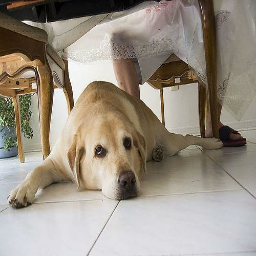

In [7]:
print(labels[1])
Image.fromarray(sample_image.numpy().astype("uint8"))

# 3. Model

In [8]:
# Prefetch the images 
train = train.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test = test.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
# define a sequential convolutional neural network model 
n_features = images.shape[1]

# define model
model = Sequential([
    tf.keras.layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(256,256,3)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(breeds))
    ])

# compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# fit the model
history = model.fit(
    train,
    validation_data=test,
    epochs=5,
    verbose=1
    )

Epoch 1/5
24/24 [==============================] - 2s 68ms/step - loss: 59.2109 - accuracy: 0.2267 - val_loss: 9.1915 - val_accuracy: 0.1946
Epoch 2/5
24/24 [==============================] - 1s 60ms/step - loss: 3.6097 - accuracy: 0.3711 - val_loss: 2.9635 - val_accuracy: 0.3027
Epoch 3/5
24/24 [==============================] - 1s 60ms/step - loss: 1.4678 - accuracy: 0.5047 - val_loss: 2.3658 - val_accuracy: 0.3297
Epoch 4/5
24/24 [==============================] - 1s 60ms/step - loss: 0.7179 - accuracy: 0.7598 - val_loss: 2.3734 - val_accuracy: 0.2757
Epoch 5/5
24/24 [==============================] - 1s 60ms/step - loss: 0.4694 - accuracy: 0.8596 - val_loss: 3.0466 - val_accuracy: 0.2595


In [14]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 flatten_2 (Flatten)         (None, 1048576)           0         
                                                                 
 dense_4 (Dense)             (None, 128)               134217856 
                                                                 
 dense_5 (Dense)             (None, 5)                 645       
                                                                 
Total params: 134,218,949
Trainable params: 134,218,949
Non-trainable params: 0
_________________________________________________________________


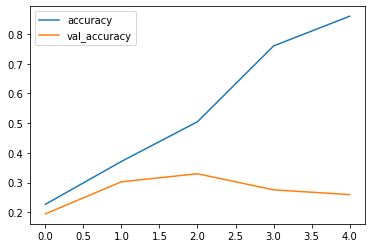

In [15]:
import pandas as pd
hist_df = pd.DataFrame(history.history) 
hist_df[["accuracy", "val_accuracy"]].plot()

In [30]:
# A function to test different models 
def nn_model(network, epochs):
  """Takes a network and the number of epochs and returns the model and history of the model
  
  Args:
    network (list): list of neural networks 
    epoch (int): number of epochs

  Returns:
    model: trained neural network model
    df: history dataframe 
  """
  # define model
  model = Sequential(network)

  # compile the model
  model.compile(optimizer='adam',
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  # fit the model
  history = model.fit(
      train,
      validation_data=test,
      epochs=epochs,
      verbose=1
      )
  
  hist_df = pd.DataFrame(history.history) 

  return model, hist_df

In [34]:
nn_2 = [tf.keras.layers.Rescaling(1./255),
    layers.Conv2D(16, 5, padding='same', activation='relu', input_shape=(256,256,3)),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 5, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 5, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu')
    layers.Dense(len(breeds))
    ]

In [26]:
model_2, history_2 = nn_model(nn_2, 8)

Epoch 1/8
24/24 [==============================] - 2s 71ms/step - loss: 1.8370 - accuracy: 0.2267 - val_loss: 1.6373 - val_accuracy: 0.2108
Epoch 2/8
24/24 [==============================] - 1s 62ms/step - loss: 1.5782 - accuracy: 0.2928 - val_loss: 1.6474 - val_accuracy: 0.2649
Epoch 3/8
24/24 [==============================] - 2s 64ms/step - loss: 1.4138 - accuracy: 0.4291 - val_loss: 1.4760 - val_accuracy: 0.3784
Epoch 4/8
24/24 [==============================] - 2s 64ms/step - loss: 1.1434 - accuracy: 0.5344 - val_loss: 1.7616 - val_accuracy: 0.3189
Epoch 5/8
24/24 [==============================] - 1s 62ms/step - loss: 0.8587 - accuracy: 0.6667 - val_loss: 2.6530 - val_accuracy: 0.2703
Epoch 6/8
24/24 [==============================] - 1s 62ms/step - loss: 0.6447 - accuracy: 0.7476 - val_loss: 2.4339 - val_accuracy: 0.3676
Epoch 7/8
24/24 [==============================] - 1s 62ms/step - loss: 0.5085 - accuracy: 0.8178 - val_loss: 2.5038 - val_accuracy: 0.3784
Epoch 8/8
24/24 [===

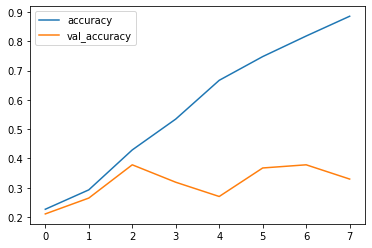

In [27]:
history_2[["accuracy", "val_accuracy"]].plot()

In [42]:
nn = [tf.keras.layers.Rescaling(1./255),
    layers.Conv2D(16, 4, padding='same', activation='relu', input_shape=(256,256,3)),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 4, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 4, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='tanh'),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(breeds))
    ]

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal", seed=1),
    layers.RandomFlip("vertical", seed=2),
    layers.RandomRotation(0.1, seed=1),
    layers.RandomZoom(0.1, seed=1),
    ])

nn_3 = [data_augmentation] + nn
model_3, history_3 = nn_model(nn_3, epochs=10)

Epoch 1/10
24/24 [==============================] - 5s 106ms/step - loss: 1.7838 - accuracy: 0.2240 - val_loss: 1.6339 - val_accuracy: 0.2162
Epoch 2/10
24/24 [==============================] - 2s 90ms/step - loss: 1.5841 - accuracy: 0.2497 - val_loss: 1.6393 - val_accuracy: 0.2486
Epoch 3/10
24/24 [==============================] - 2s 88ms/step - loss: 1.5497 - accuracy: 0.2874 - val_loss: 1.5913 - val_accuracy: 0.2973
Epoch 4/10
24/24 [==============================] - 2s 89ms/step - loss: 1.4986 - accuracy: 0.3239 - val_loss: 1.4806 - val_accuracy: 0.3784
Epoch 5/10
24/24 [==============================] - 2s 89ms/step - loss: 1.4313 - accuracy: 0.3684 - val_loss: 1.5626 - val_accuracy: 0.3459
Epoch 6/10
24/24 [==============================] - 2s 89ms/step - loss: 1.4466 - accuracy: 0.3765 - val_loss: 1.5868 - val_accuracy: 0.3459
Epoch 7/10
24/24 [==============================] - 2s 90ms/step - loss: 1.3946 - accuracy: 0.4238 - val_loss: 1.5675 - val_accuracy: 0.3459
Epoch 8/10
2

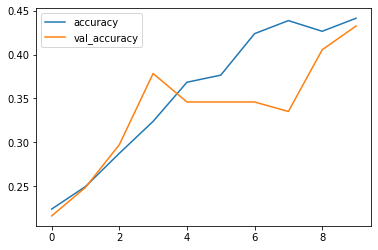

In [43]:
history_3[["accuracy", "val_accuracy"]].plot()

# 4. Prediction

In [45]:
preds = model_3.predict(test)

6/6 [==============================] - 0s 29ms/step


In [49]:
predicted_class = np.argmax(preds, axis=1)
actual_labels = np.concatenate([y for x, y in test], axis=0)
actual_class = np.argmax(actual_labels, axis=1)

In [47]:
actual_image = [x.numpy().astype("uint8") for x, y in test]
actual_image = list(itertools.chain.from_iterable(actual_image))
actual_image = [Image.fromarray(a) for a in actual_image]

In [58]:
pred_df = pd.DataFrame(zip(actual_class, predicted_class, actual_image), columns=["actual", "prediction", "image"])

In [59]:
pred_df["actual"] = pred_df["actual"].apply(lambda x: breeds[x])
pred_df["prediction"] = pred_df["prediction"].apply(lambda x: breeds[x])

In [60]:
def image_formatter(img):
    with io.BytesIO() as buffer:
        img.save(buffer, 'png')
        img_str = base64.b64encode(buffer.getvalue()).decode()
        return f'<img src="data:image/jpeg;base64,{img_str}">'

,actual,prediction,image
0,siberian_husky,siberian_husky,
1,bernese_mountain_dog,bernese_mountain_dog,
2,labrador_retriever,bernese_mountain_dog,
3,labrador_retriever,siberian_husky,
4,beagle,beagle,

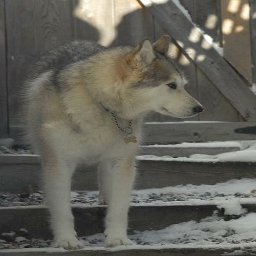
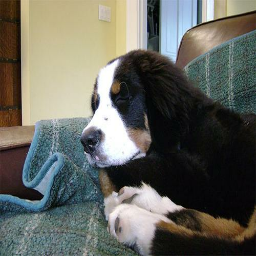
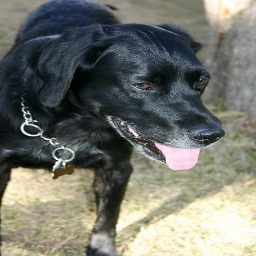
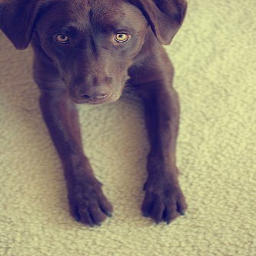
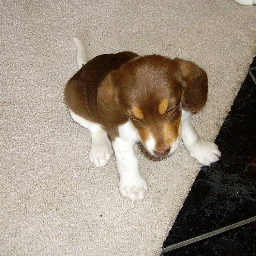

In [61]:
pred_df.head(5).style.format({'image': image_formatter})